In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import powerlaw, norm, t, cauchy, pareto, gamma, lognorm
from sklearn.linear_model import LinearRegression, HuberRegressor
import sys
import yfinance as yf

sys.path.append('../')
from src.stats import *

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
sns.set_style('darkgrid')

%matplotlib inline

# 4.1 A simple heuristic to create mildly fat tails

## Figure 4.1 - A simple normal mixture distribution

The notations in Figure 4.1 are not clear. Let me clarify the ideas. 

Let us consider the pdf of a normal distribution with zero mean as a function of variance $s$
$$
s\rightarrow f(s, x) = \frac{1}{\sqrt{2\pi s}}\exp{-\frac{x^2}{2s}}
$$
For large $x$, $f(s, x)$ is a convex function of $s$, therefore we have
$$
\frac{1}{2} f(s, x) = \frac{1}{2}f(((1-a)+(1+a))s, x) \leq \frac{1}{2}(f((1-a)s, x) + f((1+a)s, x))
$$
where $\frac{1}{2}(f((1-a)s, x) + f((1+a)s, x))$ is the pdf of $XY$ where $X$ is a normal rv with variance $s$ and $Y$ is an independent binomial random variable with $P(Y=\sqrt{1-a})=P(Y=\sqrt{1+a})=1/2$. The variance of $XY$ is 
$$
E[X^2Y^2] = E[Y^2]s = \frac{1}{2}((1-a)+(1+a))s = s
$$


In [4]:
import numpy as np
from scipy.stats import norm

class SimpleNormalMixture:
    """
    A mixture of two Gaussian distributions with the same mean but different variances.
    
    PDF formula: 1/2 * f(x, m, (1+a)s) + 1/2 * f(x, m, (1-a)s),
    where f(x, m, s) is the normal PDF with mean m and variance s.
    
    Attributes:
        m (float): The mean of both Gaussian distributions.
        s (float): The base variance used to calculate the variances of the two Gaussian distributions.
        a (float): The factor used to adjust the variance for each Gaussian distribution.
    """
    def __init__(self, m, s, a):
        self.m = m
        self.s = s
        self.a = a

    def pdf(self, x):
        s1 = (1 + self.a) * self.s
        s2 = (1 - self.a) * self.s
        return 0.5 * (norm.pdf(x, self.m, np.sqrt(s1)) + norm.pdf(x, self.m, np.sqrt(s2)))

    def cdf(self, x):
        s1 = (1 + self.a) * self.s
        s2 = (1 - self.a) * self.s
        return 0.5 * (norm.cdf(x, self.m, np.sqrt(s1)) + norm.cdf(x, self.m, np.sqrt(s2)))

    def rvs(self, size=None):
        s1 = (1 + self.a) * self.s
        s2 = (1 - self.a) * self.s
        choices = np.random.choice([s1, s2], size=size, p=[0.5, 0.5])
        return norm.rvs(loc=self.m, scale=np.sqrt(choices))

    def mean(self):
        return self.m

    def var(self):
        return self.s
    
    def std(self):
        return np.sqrt(self.s)


### Plot PDFs, i.e. f(s, x) as a function of x

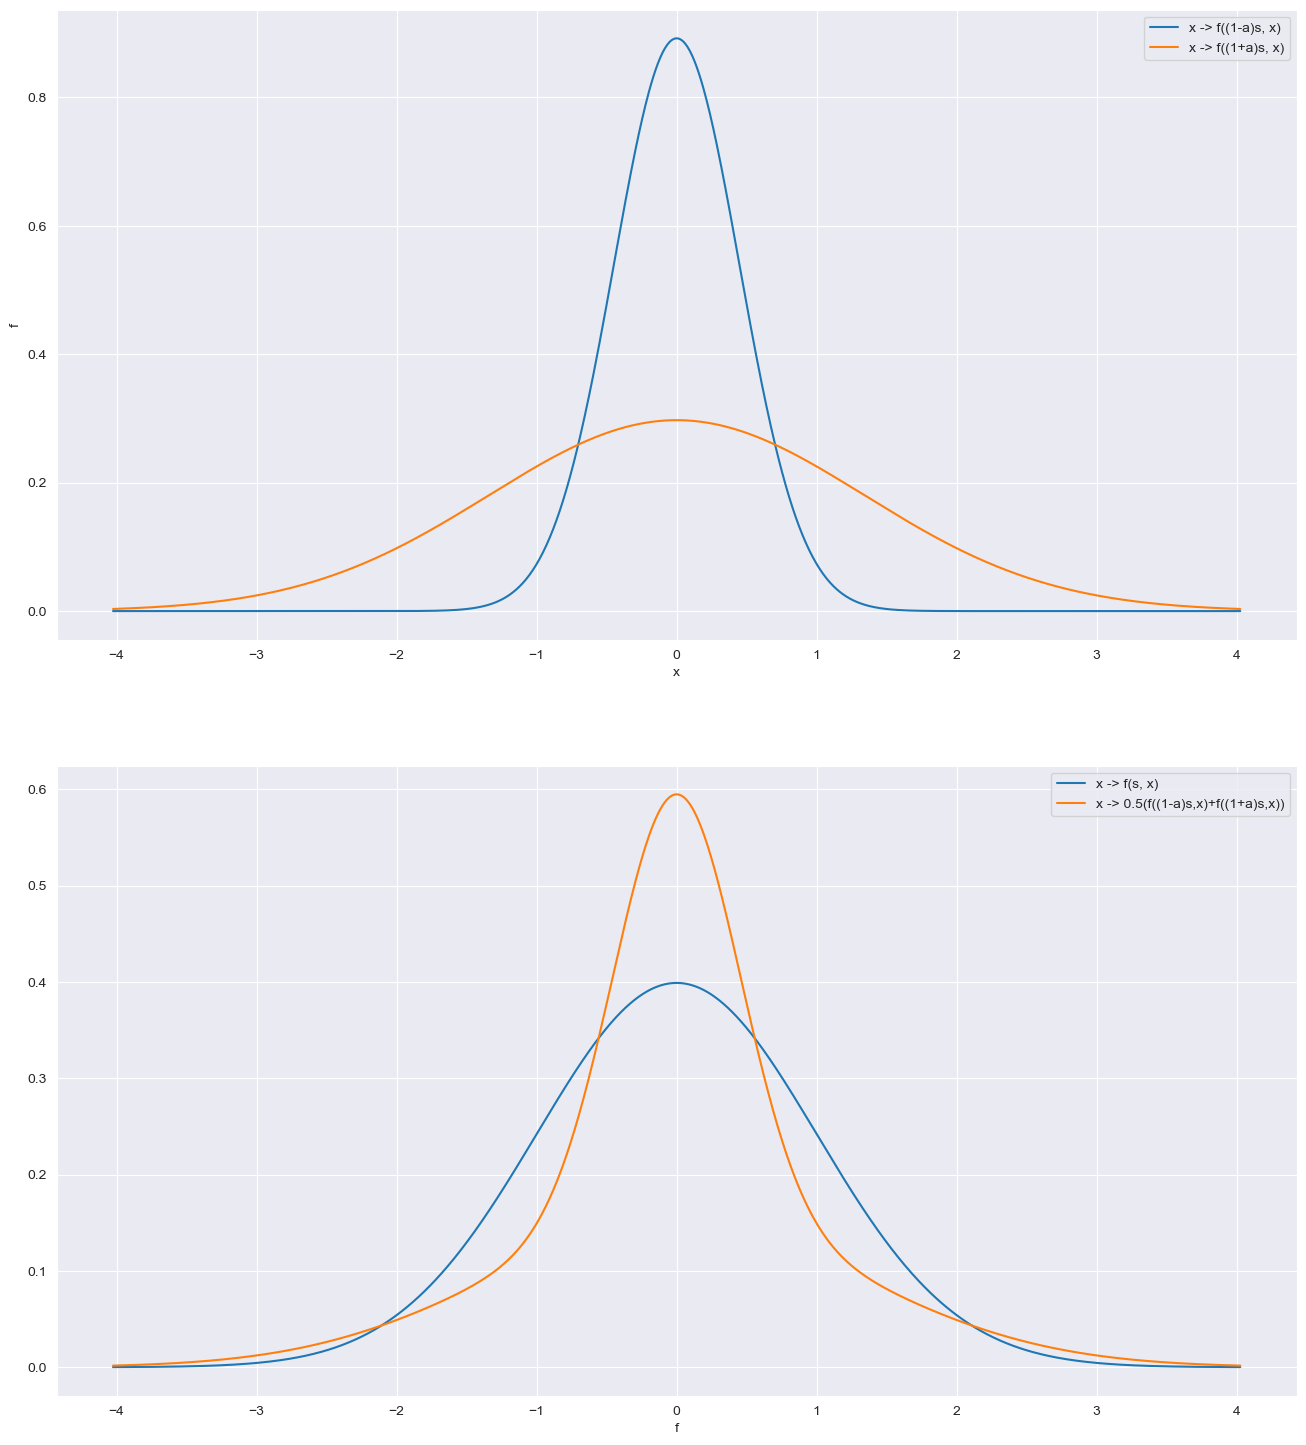

In [29]:
# Set values of x, a, s
m = 0
s = 1
a = 0.8
x = np.linspace(-3*np.sqrt(1+a), 3*np.sqrt(1+a), 1000)

snm = SimpleNormalMixture(m, s, a)

# Plot the PDFs of the simple normal mixture distribution
fig, axs = plt.subplots(2, 1, figsize=(16, 18))

axs[0].plot(x, norm.pdf(x, m, np.sqrt(1-a)*s), label='x -> f((1-a)s, x)')
axs[0].plot(x, norm.pdf(x, m, np.sqrt(1+a)*s), label='x -> f((1+a)s, x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f')
axs[0].legend()

axs[1].plot(x, norm.pdf(x, m, s), label='x -> f(s, x)')
axs[1].plot(x, snm.pdf(x), label='x -> 0.5(f((1-a)s,x)+f((1+a)s,x))')
axs[1].set_xlabel('x')
axs[1].set_xlabel('f')
axs[1].legend()

### Plot f(s, x) as a function of s

Text(0, 0.5, 'f')

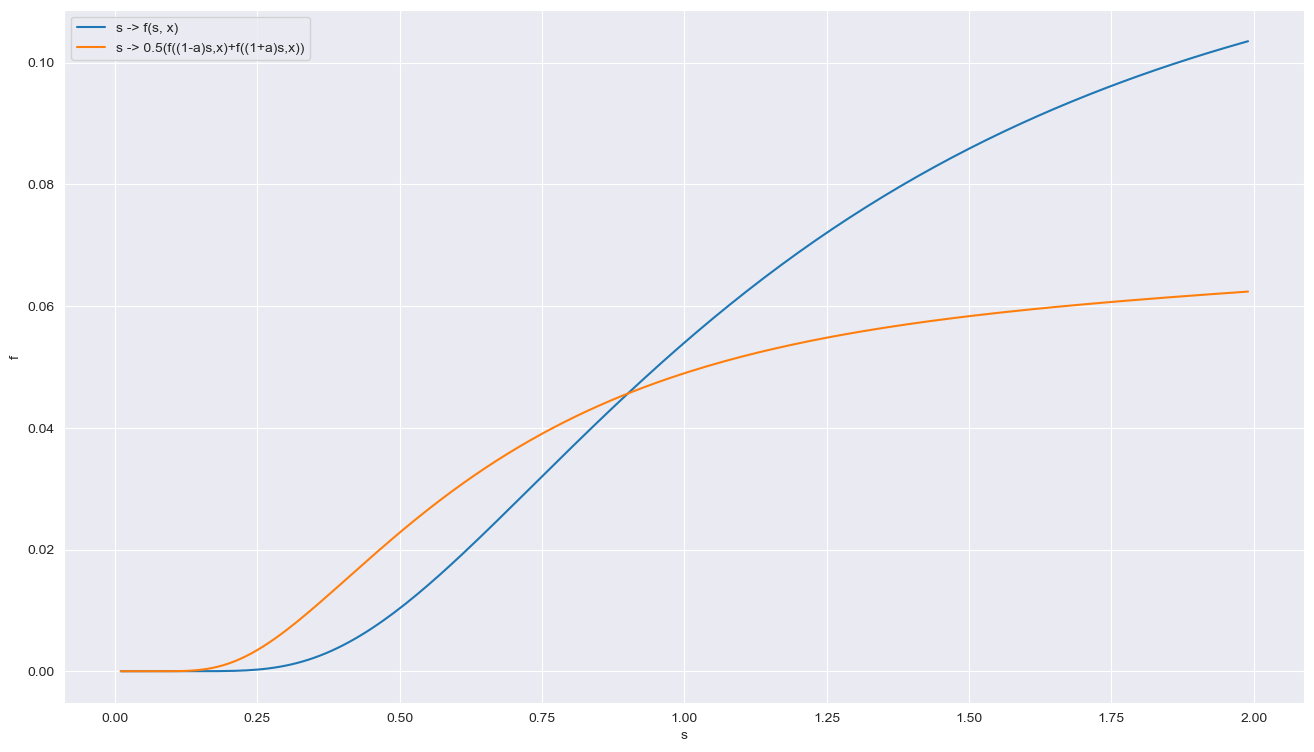

In [30]:
# Set values of x, a, s
s = np.arange(0.01, 2, 0.01)
a = 0.8
x = 2

# Simple normal pdf as a function of s
def func(s, x):
    return norm.pdf(x, scale=np.sqrt(s))

# Figure that compares the functions
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(s, func(s, x), label='s -> f(s, x)')
ax.plot(s, 0.5*(func((1-a)*s, x)+func((1+a)*s, x)), label='s -> 0.5(f((1-a)s,x)+f((1+a)s,x))')
ax.legend()
ax.set_xlabel('s')
ax.set_ylabel('f')

## Figure 4.2: Stochastic Variance: Gamma distribution and Lognormal of same mean and variance.

Note: I believe that the parameterization $gamma(k,\theta)$ in the figures is from [wiki](https://en.wikipedia.org/wiki/Gamma_distribution). The paramterization $(\alpha, V)$ in the text corresponds to $V=k\theta$ and $a=k$.

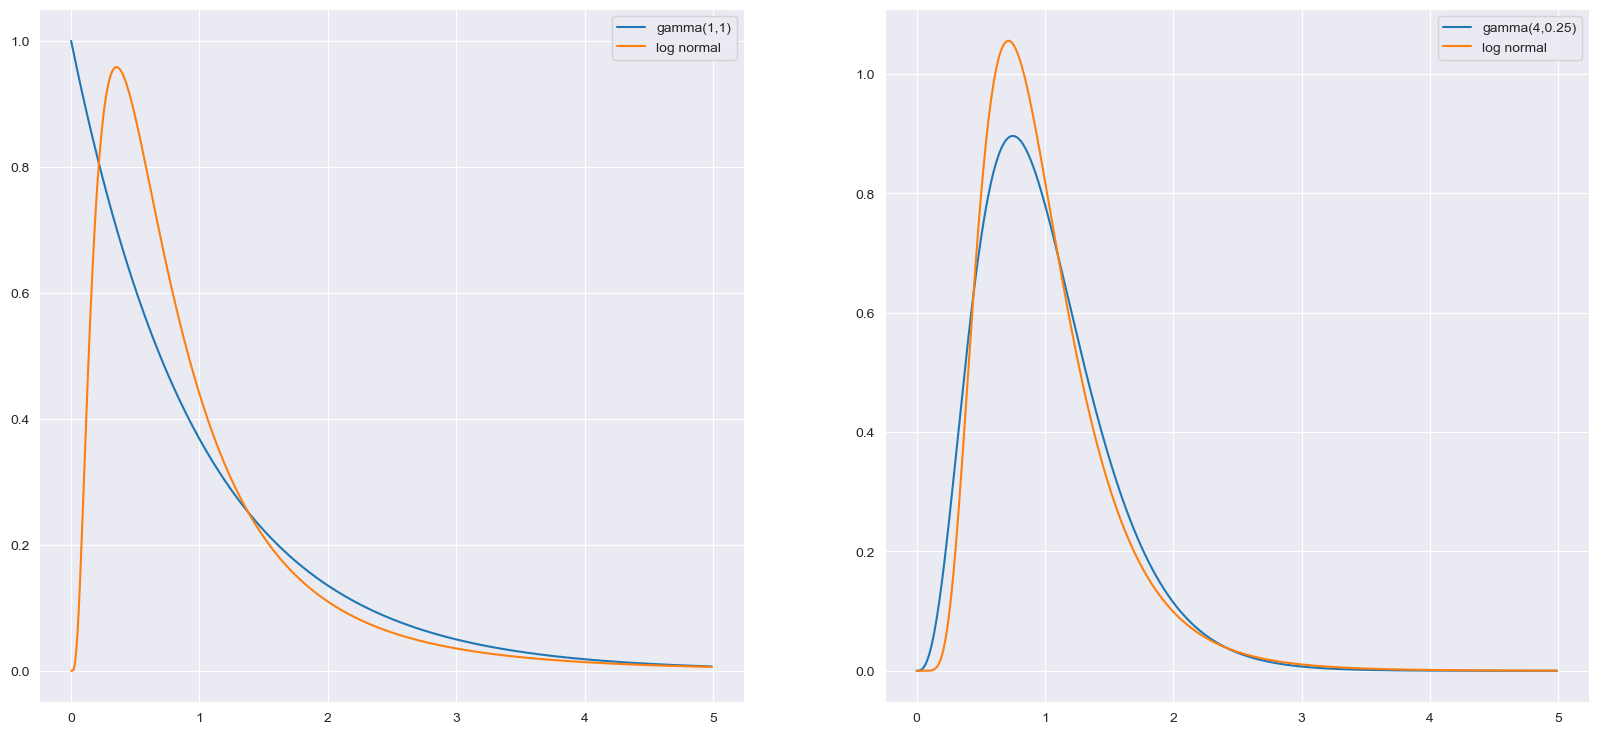

In [96]:
x = np.arange(0, 5, 0.01)

fig, axs = plt.subplots(1, 2, figsize=(20, 9))

# Gamma parameters
k = 1
theta = 1
gamma_mean = gamma.mean(k, loc=0, scale=theta)
gamma_var = gamma.var(k, loc=0, scale=theta)

# Parameters for log-normal distribution
mu, sigma = lognorm_params_from_mean_and_variance(gamma_mean, gamma_var)

axs[0].plot(x, gamma.pdf(x, k, loc=0, scale=theta), label='gamma({},{})'.format(str(k),str(theta)))
axs[0].plot(x, lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu)), label='log normal')
axs[0].legend()

# Gamma parameters
k = 4
theta = 1/4
gamma_mean = gamma.mean(k, loc=0, scale=theta)
gamma_var = gamma.var(k, loc=0, scale=theta)

# Parameters for log-normal distribution
mu, sigma = lognorm_params_from_mean_and_variance(gamma_mean, gamma_var)

axs[1].plot(x, gamma.pdf(x, k, loc=0, scale=theta), label='gamma({},{})'.format(str(k),str(theta)))
axs[1].plot(x, lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu)), label='log normal')
axs[1].legend()

## Figure 4.3: Variance Gamma distribution

The pdf (4.7) in the book is only for the symmetric variance gamma (VG) distribution. Here we follow the definition from [wiki](https://en.wikipedia.org/wiki/Variance-gamma_distribution) and [mathematica](https://reference.wolfram.com/language/ref/VarianceGammaDistribution.html).



In [190]:
import scipy

class UnivariateVarianceGamma:
    def __init__(self, mu, alpha, beta, lam):
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.lam = lam

    def pdf(self, x):
        numerator = (self.alpha ** (2 * self.lam)) * (np.abs(x - self.mu) ** (self.lam - 0.5)) * scipy.special.kv(self.lam - 0.5, self.alpha * np.abs(x - self.mu))
        denominator = (np.sqrt(np.pi) * scipy.special.gamma(self.lam) * (2 * self.alpha) ** (self.lam - 0.5))
        return (numerator / denominator) * np.exp(self.beta * (x - self.mu))
    
    def rvs(self, size):
        theta = 2/(self.alpha**2 - self.beta**2)
        gamma_rvs = gamma.rvs(self.lam, loc=0, scale=theta, size=size)
        norm_rvs = norm.rvs(loc=0, scale=1, size=size)
        return mu + self.beta*gamma_rvs + np.sqrt(gamma_rvs)*norm_rvs
    
    def var(self):
        theta = 2/(self.alpha**2 - self.beta**2)
        return self.lam*theta * (1 + self.beta**2 * theta)
    
    def mean(self):
        return self.mu + self.beta*self.lam/np.sqrt((self.alpha**2 - self.beta**2)/2)
        

0.5993251151541777 4.110037198952947
0.7157323781925193 4.122028364452607


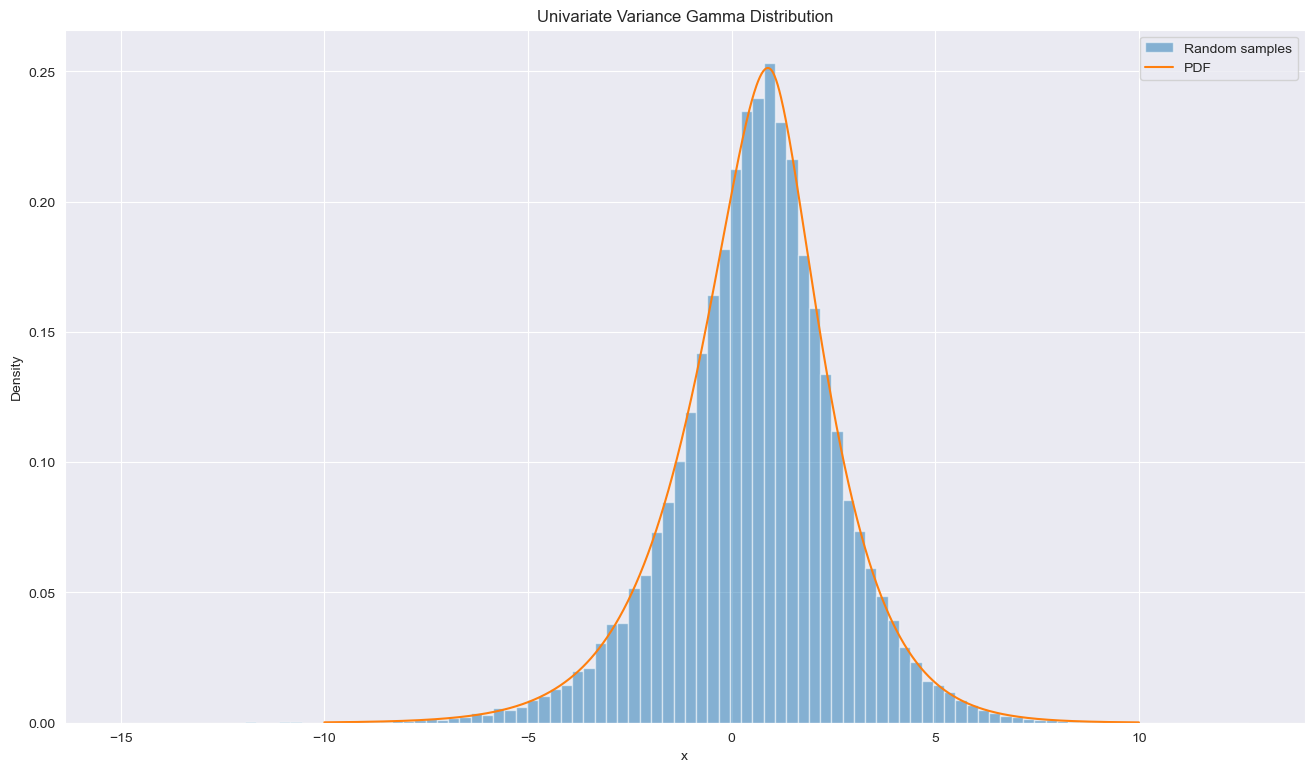

In [193]:
# Parameters for the UnivariateVarianceGamma distribution
mu = 1
alpha = 1
beta = -0.1
lam = 2

# Create an instance of the UnivariateVarianceGamma class
vg_dist = UnivariateVarianceGamma(mu, alpha, beta, lam)

# Generate random samples
sample_size = 50000
random_samples = vg_dist.rvs(size=sample_size)

print(np.mean(random_samples), np.var(random_samples))
print(vg_dist.mean(), vg_dist.var())

# Create the plot
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(random_samples, bins=100, density=True, alpha=0.5, label='Random samples')

# Evaluate the PDF and overlay it on the histogram
x = np.linspace(-10, 10, 1000)
pdf_values = vg_dist.pdf(x)
ax.plot(x, pdf_values, label='PDF')

# Customize the plot
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Univariate Variance Gamma Distribution')
ax.legend()
plt.show()

In [180]:
vg = UnivariateVarianceGamma(0, 1.0, 0.2, 5.0)
x = vg.rvs(2000)

In [150]:
y, xi = np.histogram(x, bins=100)
y = y

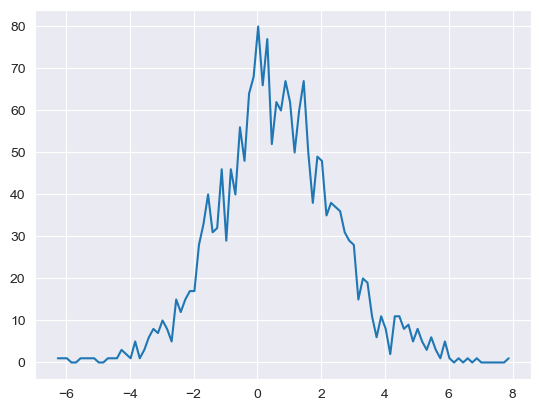

In [142]:
x = np.arange(-10, 10, 0.01)

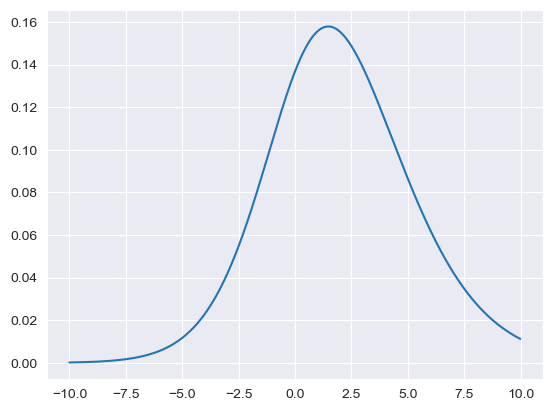

In [143]:
plt.plot(x, vg.pdf(x))

In [77]:
def pdf_one_point(x=0.0, mu=0.0, sigma=1.0, theta=0.0, alpha=1.0):
	''' VarGamma probability density function in a point x '''
	temp1 = 2.0 / ( sigma*(2.0*pi)**0.5*nu**alpha*special.gamma(alpha) )
	temp2 = ((2*sigma**2*alpha+theta**2)**0.5)**(0.5-alpha)
	temp3 = exp(theta*(x-mu)/sigma**2) * abs(x-mu)**(alpha - 0.5)
	temp4 = special.kv(alpha - 0.5, np.abs(x-mu)*(2*sigma**2*alpha+theta**2)**0.5/sigma**2)
	return temp1*temp2*temp3*temp4

In [82]:
lognorm.mean(sigma, 0, np.exp(mu))

1.0

In [83]:
lognorm.var(sigma, 0, np.exp(mu))

0.25

In [81]:
(np.exp(sigma**2)-1)*np.exp(2*mu+sigma**2)

0.25

# 4.4 fat tails, mean deviation and the rising norms

## Figure 4.6: The Ratio STD/MAD for the daily returns of the SP500 

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'SP500 STD/MAD')

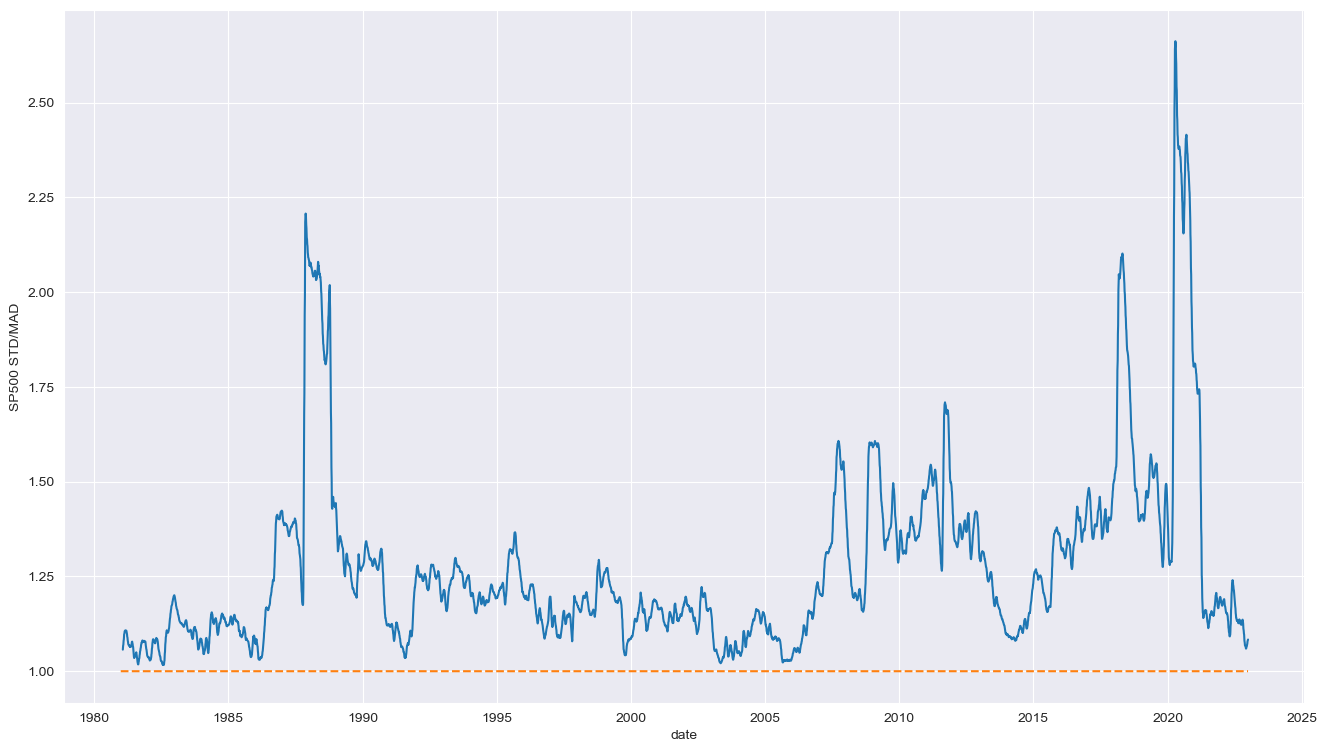

In [51]:
start_date = '1980-01-01'
end_date = '2023-01-01'
std_window = 250
rolling_window = 20

# Download SP500 data
data = yf.download('^GSPC', start=start_date, end=end_date)
sp_return = data['Adj Close'].pct_change().dropna()

# Compute std and mad (here MAD is already re-scaled to match normal std)
std = sp_return.rolling(std_window).std().dropna()
mad = sp_return.rolling(std_window).apply(median_absolute_deviation).dropna()

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((std/mad).rolling(rolling_window).mean())
ax.plot(pd.Series(1, index=std.index), '--')
ax.set_xlabel('date')
ax.set_ylabel('SP500 STD/MAD')

In [43]:
1/np.sqrt(np.pi/2)

0.7978845608028654

In [44]:
1.253

1.253

In [46]:
1.253/2

0.6265